# Predicting the Chromatic Number and Maximum Clique Size of a Graph

Authors: Josh Friedman and Jason Van Hulse

***

This notebook presents the convolutional neural network models that we have trained to learn the chromatic number $\chi(G)$ and maximum clique size $\omega(G)$ of a graph. Datasets of 50 by 50 graphs were generated with known values for $\chi(G)$ and $\omega(G)$. The input into the CNN model is the graph adjacency matrix; no domain-specific feature engineering was applied to the graphs. 

This notebook assumes that you have data in your local file system that has the following format:

* Column 1: chromatic number $\chi(G)$
* Column 2: maximum clique size $\omega(G)$
* Columns 3+: entries of the graph adjacency matrix

The code will read in the data and perform the appropriate transformations before model fitting. 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf


## Section 1: Importing and Transforming the Raw Data




In [ ]:
from google.colab import drive
drive.mount("/data")

Drive already mounted at /data; to attempt to forcibly remount, call drive.mount("/data", force_remount=True).


In [ ]:
def data_prep(data_loc, num_graph_vertices = 50):
    '''
    **************************
    Description: This function reads in the raw data at location data_loc and returns 
            data structures that can be used to train and evaluate CNN models
    **************************        
    input: location of the data
    output: three data structures that contain the input graph adjacency matrix as a 50 x 50 array (x_c), 
            the chromatic number (y_chrom), and the maximum clique size (y_mcs)
            Note that both y_chrom and y_mcs are scaled to be between 0 and 1; they can 
            be transformed to the original values by multiplying by the number of vertices in the 
            graph
    '''
    raw_data = pd.read_csv(data_loc).to_numpy()
    np.random.shuffle(raw_data)

    x = raw_data[:, 2:]
    x_c = x.reshape((len(x), num_graph_vertices, num_graph_vertices))
    x_c = tf.expand_dims(x_c, -1)

    y_chrom = raw_data[:, 0]/num_graph_vertices

    y_mcs = raw_data[:, 1]/num_graph_vertices

    return(x_c, y_chrom, y_mcs)


In [ ]:
x_train, y_train_chrom, y_train_mcs = data_prep("/data/My Drive/Data/Apr30/train.csv")
x_dev, y_dev_chrom, y_dev_mcs = data_prep("/data/My Drive/Data/Apr30/dev.csv")
x_test, y_test_chrom, y_test_mcs = data_prep("/data/My Drive/Data/Apr30/test.csv")

## Section 2: Additional Evaluation Functions

This section provides a few helpful functions for evaluating the output of the CNN models. 

In [ ]:
def create_df_output(clf, y, df):
  '''
    Creates an output dataframe that can be inspected and analyzed to better understand the predictions 
    of the deep neural network. For each record in the input dataframe `df`, the actual and predicted 
    values and the error and absolute error `abs_error` are computed. 
    Note that because we scaled the target variable to be between 0 and 1, we rescale the target 
    to its original value and likewise scale up the prediction. 
  '''
  df_output = pd.DataFrame()
  df_output['actual'] = y*50
  df_output['pred'] = clf.predict(df)*50
  df_output['error'] = df_output.actual - df_output.pred
  df_output['abs_error'] = np.abs(df_output['error'])

  return(df_output)

def show_percentiles(df):
    '''
    Returns the percentiles of the absolute error metric for the input dataframe `df`
    '''
    return(df['abs_error'].describe(percentiles = [.25, .50, .75, .90, .95, .99, 1.00]))

def compute_pl(df, diff):
    '''
    Computes the metric p_l, which shows the percentage of records in the dataset
    with an absolute error <= diff, a user input parameter (typically 0.5 or 1)
    '''
    print("% within ", diff, "of true chromatic or clique #:", 
          100 * np.sum(df['abs_error']<= diff) / np.sum(df['abs_error']>= 0))


## Section 3: Sequential Convolutional Neural Network

In this section, we define a sequential convolutional neural network architecture to predict the chromatic number and maximum clique size. 

The CNN consists of a `Conv2D` layer with 512 filters and `kernel_size` = (3,3), followed by a `MaxPooling2D` layer with `pool_size`= 2 and a `LeakyReLU` layer. A `Conv2D` layer with 64 filters, `MaxPooling` layer, and `LeakyReLU` layer follow. 

The output is then flattened and processed through a series of dense layers with 300 hidden nodes per layer and `LeakyReLU` activation function. 

In [ ]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping


tf.keras.backend.clear_session()

class Cnn(tf.keras.Model):

    def __init__(self):
        super(Cnn, self).__init__()
        self.inp = InputLayer(input_shape = (50, 50, 1))
        self.conv1 = Conv2D(512, 3, padding = 'same')
        self.lr1 = LeakyReLU(0.05)
        self.mp1 = MaxPooling2D(2) 
        self.conv2 = Conv2D(64, 3, padding = 'same')
        self.lr2 = LeakyReLU(0.05)
        self.mp2 = MaxPooling2D(2) 
    
        self.flatten = Flatten()
        self.dense1 = Dense(300) 
        self.lr3 = LeakyReLU(0.05)
        self.dense2 = Dense(300)
        self.lr4 = LeakyReLU(0.05)
        self.dense3 = Dense(300)
        self.lr5 = LeakyReLU(0.05)
        self.dense4 = Dense(300)
        self.lr6 = LeakyReLU(0.05)
        self.dense5 = Dense(300)
        self.lr7 = LeakyReLU(0.05)
        self.dense6 = Dense(300)
        self.lr8 = LeakyReLU(0.05)
        self.dense7 = Dense(300)
        self.lr9 = LeakyReLU(0.05)
    
        self.out = Dense(1, activation = 'linear')

    def call(self, inputs):
        x = self.inp(inputs)
        x = self.conv1(x)
        x = self.lr1(x)
        x = self.mp1(x)
        x = self.conv2(x)
        x = self.lr2(x)
        x = self.mp2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.lr3(x)
        x = self.dense2(x)
        x = self.lr4(x)
        x = self.dense3(x)
        x = self.lr5(x)
        x = self.dense4(x)
        x = self.lr6(x)
        x = self.dense5(x)
        x = self.lr7(x)
        x = self.dense6(x)
        x = self.lr8(x)
        x = self.dense7(x)
        x = self.lr9(x)
        return self.out(x)



### Predicting the Chromatic Number

In [ ]:
cnn_chrom = Cnn()

cnn_chrom.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MAE)

early_stopping_callback = EarlyStopping(patience = 50, monitor = 'val_loss', restore_best_weights = True, 
                                        min_delta = 0.000001)

cnn_chrom.fit(x_train, y_train_chrom, validation_data= (x_dev, y_dev_chrom), 
                      epochs = 500, verbose = 0, 
                      callbacks = [early_stopping_callback])

cnn_chrom.evaluate(x = x_dev, y = y_dev_chrom)

782/782 [==============================] - 4s 5ms/step - loss: 0.0086


0.008576658554375172

In [ ]:
out = create_df_output(cnn_chrom, y_test_chrom, x_test)

show_percentiles(out)

count    24999.000000
mean         0.426984
std          0.439606
min          0.000010
25%          0.122424
50%          0.310355
75%          0.599364
90%          0.909940
95%          1.169851
99%          2.234732
100%         5.463226
max          5.463226
Name: abs_error, dtype: float64

In [ ]:
out['per_error'] = 100 * out['abs_error']/out['actual']

out['per_error'].describe()

count    24999.000000
mean         5.489368
std          6.802970
min          0.000286
25%          1.611137
50%          3.611746
75%          6.804798
max         77.306724
Name: per_error, dtype: float64

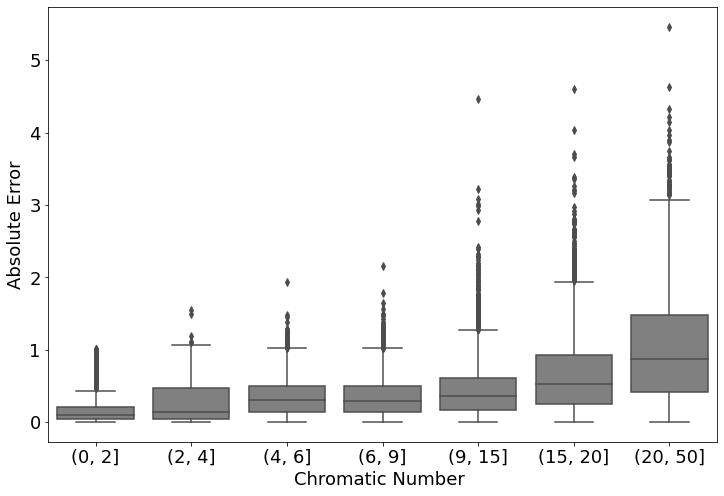

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

gps = [0, 2, 4, 6, 9, 15, 20, 50]

out['groups'] = pd.cut(out['actual'], bins = gps)

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(12, 8))
sns.boxplot(data= out, x = 'groups', y = 'abs_error', color = 'grey')
#plt.title("Absolute Error Distribution by Chromatic Number")
plt.ylabel("Absolute Error")
plt.xlabel("Chromatic Number ")
plt.show()  

In [ ]:
compute_pl(out, 1)
compute_pl(out, 0.5)

% within  1 of true chromatic or clique #: 92.62370494819793
% within  0.5 of true chromatic or clique #: 67.95471818872755


### Predicting the Maximum Clique Size

In [ ]:
cnn_mcs = Cnn()

cnn_mcs.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MAE)

cnn_mcs.fit(x_train, y_train_mcs, validation_data= (x_dev, y_dev_mcs), 
                      epochs = 500, verbose = 0, 
                      callbacks = [early_stopping_callback])

cnn_mcs.evaluate(x = x_dev, y = y_dev_mcs)

782/782 [==============================] - 4s 5ms/step - loss: 0.0110


0.01104268804192543

In [ ]:
out = create_df_output(cnn_mcs, y_test_mcs, x_test)

show_percentiles(out)

count    24999.000000
mean         0.548836
std          0.548158
min          0.000019
25%          0.099669
50%          0.381279
75%          0.886556
90%          1.199483
95%          1.563155
99%          2.399153
100%         5.558903
max          5.558903
Name: abs_error, dtype: float64

In [ ]:
out['per_error'] = 100 * out['abs_error']/out['actual']

out['per_error'].describe()

count    24999.000000
mean         7.412665
std          8.902003
min          0.000528
25%          1.808377
50%          4.299364
75%         10.022158
max        101.062083
Name: per_error, dtype: float64

In [ ]:
compute_pl(out, 1)
compute_pl(out, 0.5)

% within  1 of true chromatic or clique #: 81.57126285051402
% within  0.5 of true chromatic or clique #: 56.506260250410016


## Section 4: Wide Convolutional Neural Network

The wide CNN consists of five parallel convolutional pipelines with different size filters and strides in order to capture different relationships between vertices in the graph. Another way to think about this architecture is that it augments the sequential CNN (which only considers 3 by 3 kernels) with additional convolutional pipelines with larger kernels. 

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, LeakyReLU, Concatenate
from tensorflow.keras.models import Model

tf.keras.backend.clear_session()

class Wide_cnn(tf.keras.Model):

    def __init__(self):
        super(Wide_cnn, self).__init__()
        self.inp = InputLayer(input_shape = (50, 50, 1))

        self.conv2d_0_1 = Conv2D(512, kernel_size=(3,3), strides = 1, padding = 'same')
        self.lr_0_1 = LeakyReLU(alpha = 0.05)
        self.mp_0_1 = MaxPooling2D(2)
        self.conv2d_0_2 = Conv2D(64, kernel_size=(3,3), strides = 1, padding = 'same')
        self.lr_0_2 = LeakyReLU(alpha = 0.05)
        self.mp_0_2 = MaxPooling2D(2)
        self.flatten_0 =  Flatten()

        self.conv2d_1_1 = Conv2D(512, kernel_size = (5,5), strides = 5, padding = 'same')
        self.lr_1_1 = LeakyReLU(alpha=0.05)
        self.mp_1_1 = MaxPooling2D(2)
        self.conv2d_1_2 =Conv2D(64, kernel_size = (5,5), strides = 1, padding = 'same')
        self.lr_1_2 = LeakyReLU(alpha=0.05)
        self.flatten_1 = Flatten()

        self.conv2d_2_1 = Conv2D(512, kernel_size = (10,10), strides = 10, padding = 'same')
        self.lr_2_1 = LeakyReLU(alpha=0.05)
        self.mp_2_1 = MaxPooling2D(2)
        self.conv2d_2_2 = Conv2D(64, kernel_size = (10,10), strides = 1, padding = 'same')
        self.lr_2_2  = LeakyReLU(alpha=0.05)
        self.flatten_2 = Flatten()

        self.conv2d_3_1 = Conv2D(512, kernel_size = (25,25), strides = 25, padding = 'same')
        self.lr_3_1 = LeakyReLU(alpha=0.05)
        self.flatten_3 =  Flatten()

        self.conv2d_4_1 =  Conv2D(512, kernel_size = (50, 50), strides = 50, padding = 'same')
        self.lr_4_1 =  LeakyReLU(alpha=0.05)
        self.flatten_4 = Flatten()

        self.concatenate = Concatenate()

        self.dense_1 = Dense(200)
        self.lr_1 = LeakyReLU(alpha=0.05)
        self.dense_2  = Dense(200)  
        self.lr_2 = LeakyReLU(alpha=0.05)
        self.dense_3 = Dense(200)
        self.lr_3 = LeakyReLU(alpha=0.05)
        self.dense_4 = Dense(200)
        self.lr_4  = LeakyReLU(alpha=0.05)
        self.dense_5  = Dense(200)
        self.lr_5  = LeakyReLU(alpha=0.05)

        self.out  = Dense(1, activation = 'linear')

    def call(self, inputs):
        i = self.inp(inputs)

        x0 = self.conv2d_0_1(i)
        x0 = self.lr_0_1(x0)
        x0 = self.mp_0_1(x0)
        x0 = self.conv2d_0_2(x0)
        x0 = self.lr_0_2(x0)
        x0 = self.mp_0_2(x0)
        x0 = self.flatten_0(x0)

        x1 = self.conv2d_1_1(i)
        x1 = self.lr_1_1(x1)
        x1 = self.mp_1_1(x1)
        x1 = self.conv2d_1_2(x1)
        x1 = self.lr_1_2(x1)
        x1 = self.flatten_1(x1)

        x2 = self.conv2d_2_1(i)
        x2 = self.lr_2_1(x2)
        x2 = self.mp_2_1(x2)    
        x2 = self.conv2d_2_2(x2)
        x2 = self.lr_2_2(x2)
        x2 = self.flatten_2(x2)

        x3 = self.conv2d_3_1(i) 
        x3 = self.lr_3_1(x3)
        x3 = self.flatten_3(x3)

        x4 = self.conv2d_4_1(i)
        x4 = self.lr_4_1(x4)
        x4 = self.flatten_4(x4)

        x = self.concatenate([x0, x1, x2,x3,x4])

        x = self.dense_1(x)
        x = self.lr_1(x)
        x = self.dense_2(x)
        x = self.lr_2(x)
        x = self.dense_3(x)
        x = self.lr_3(x)
        x = self.dense_4(x)
        x = self.lr_4(x)
        x = self.dense_5(x)
        x = self.lr_5(x)

        return self.out(x)

### Predicting the Chromatic Number

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(patience = 20, monitor = 'val_loss', restore_best_weights = True, 
                                        min_delta = 0.000001)

wide_cnn_chrom = Wide_cnn()

wide_cnn_chrom.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MAE)

wide_cnn_chrom.fit(x_train, y_train_chrom, validation_data = (x_dev, y_dev_chrom), 
                      epochs = 300, verbose = 0, callbacks = [early_stopping_callback])

wide_cnn_chrom.evaluate(x = x_dev, y = y_dev_chrom)

782/782 [==============================] - 5s 7ms/step - loss: 0.0076


0.007648102007806301

In [ ]:
out = create_df_output(wide_cnn_chrom, y_test_chrom, x_test)

show_percentiles(out)

count    24999.000000
mean         0.384710
std          0.433855
min          0.000000
25%          0.029888
50%          0.239033
75%          0.612763
90%          0.989220
95%          1.096496
99%          1.853118
100%         4.733044
max          4.733044
Name: abs_error, dtype: float64

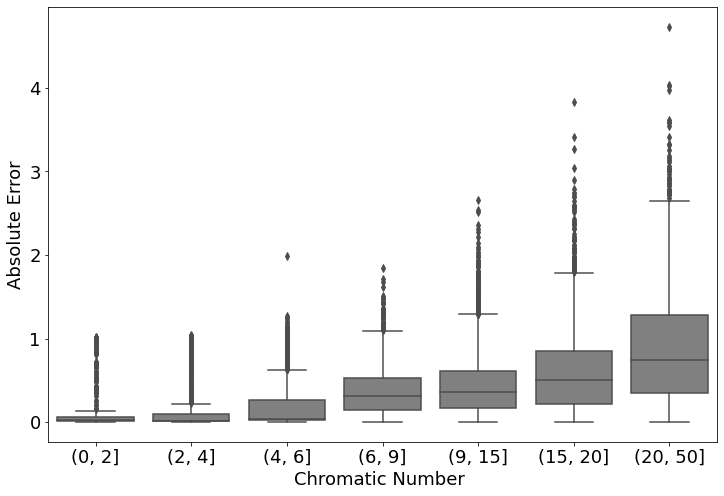

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

gps = [0, 2, 4, 6, 9, 15, 20, 50]

out['groups'] = pd.cut(out['actual'], bins = gps)

plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(12, 8))
sns.boxplot(data= out, x = 'groups', y = 'abs_error', color = 'grey')
#plt.title("Absolute Error Distribution by Chromatic Number")
plt.ylabel("Absolute Error")
plt.xlabel("Chromatic Number ")
plt.show()  

In [ ]:
out['per_error'] = 100 * out['abs_error']/out['actual']

out['per_error'].describe()

count    24999.000000
mean         4.625109
std          6.966126
min          0.000000
25%          0.543304
50%          2.206945
75%          5.546584
max         50.642192
Name: per_error, dtype: float64

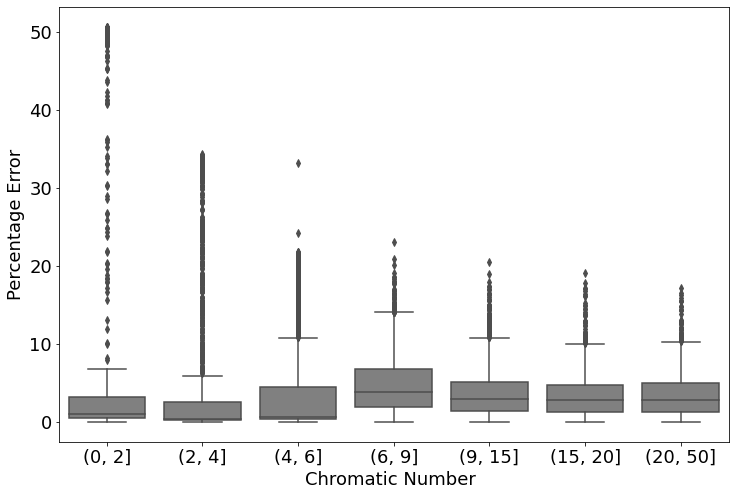

In [ ]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(12, 8))
sns.boxplot(data= out, x = 'groups', y = 'per_error', color = 'grey')
#plt.title("Absolute Error Distribution by Chromatic Number")
plt.ylabel("Percentage Error")
plt.xlabel("Chromatic Number ")
plt.show()  

In [ ]:
compute_pl(out, 1)
compute_pl(out, 0.5)

% within  1 of true chromatic or clique #: 90.86763470538821
% within  0.5 of true chromatic or clique #: 68.6947477899116


In [ ]:
wide_cnn_chrom.summary()

Model: "wide_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  5120      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  294976    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0  

### Predicting the Maximum Clique Size

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(patience = 20, monitor = 'val_loss', restore_best_weights = True, 
                                        min_delta = 0.000001)

wide_cnn_mcs = Wide_cnn()

wide_cnn_mcs.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MAE)

wide_cnn_mcs.fit(x_train, y_train_mcs, 
                      validation_data = (x_dev, y_dev_mcs), 
                      epochs = 300, verbose = 0, callbacks = [early_stopping_callback])

wide_cnn_mcs.evaluate(x = x_dev, y = y_dev_mcs)

782/782 [==============================] - 6s 7ms/step - loss: 0.0095


0.009527258574962616

In [ ]:
out = create_df_output(wide_cnn_mcs, y_test_mcs, x_test)

show_percentiles(out)

count    24999.000000
mean         0.473283
std          0.479709
min          0.000008
25%          0.047849
50%          0.333809
75%          0.806319
90%          1.029794
95%          1.327928
99%          2.038780
100%         4.348522
max          4.348522
Name: abs_error, dtype: float64

In [ ]:
out['per_error'] = 100 * out['abs_error']/out['actual']

out['per_error'].describe()

count    24999.000000
mean         6.690554
std          8.764792
min          0.000191
25%          0.854565
50%          3.542391
75%          8.518054
max         72.173357
Name: per_error, dtype: float64

In [ ]:
compute_pl(out, 1)
compute_pl(out, 0.5)

% within  1 of true chromatic or clique #: 87.95151806072244
% within  0.5 of true chromatic or clique #: 60.13840553622145
